# Question 6.

Reproducing Figure 3b - Time series of daily SSTs, smoothed with a 30 day running mean, in the northern part of the CCUS (Newport 45N) SST 1 km offshore.

In [13]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec
import math

import xarray as xr
xr.set_options(display_style="html")  # display dataset nicely

import warnings
warnings.simplefilter("ignore")  # filter some warning messages

# code features from https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html
crs = ccrs.PlateCarree()  # set projection

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from pathlib import Path

# Small style adjustments for more readable plots
plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 14

### Import Data

In [15]:
ds = xr.open_dataset("~/shared/climate-data/ds_hw.nc")

In [16]:
#Monterey and Newport's latitude and longitude
mont = {"name": "Monterey", "lat": 36.598, "lon": -121.8922}
newport = {"name": "Newport", "lat": 45, "lon": -124.061}

### Offshore longitude Calculation

In [17]:
#calculate offshore longitude, default distance: 1000 km 
def offshore_coordinate(curr_lat, curr_lon, d=1000):
    Earthradius = 6378  #6378 km
    
    curr_lon_radian = curr_lon * math.pi/180
    curr_lat_radian = curr_lat * math.pi/180
    
    latitude_radius = Earthradius * math.cos(curr_lat_radian)
    longitude = (curr_lon_radian - d/latitude_radius)*180/math.pi
    
    return longitude

### Figure 3b (Newport SST 1 km offshore)

In [18]:
#Longitude at the 1000 km offshore location 
newport_offshore_lon = offshore_coordinate(newport['lat'], newport['lon'], d=1)
newport_offshore_lat = newport['lat']

#30 day running average (converting SST unit from kelvin to celsius)
averaged_SST = ds.analysed_sst.sel(lat=newport_offshore_lat,
                      lon=newport_offshore_lon, 
                      method='nearest').rolling(time=30, center=True).mean() - 273.15

#smoothed daily SST during 2014
SST_2014 = averaged_SST.sel(time="2014")

#smoothed daily SST during 2015
SST_2015 = averaged_SST.sel(time="2015")

#smoothed daily SST during 2016
SST_2016 = averaged_SST.sel(time="2016")

In [19]:
#smoothed daily SST 2002-2013
ds_0213 = averaged_SST.sel(time=slice("2002", "2013"))

#determine the mean, max, min, 1sd bounds of the smoothed daily SST 2002-2013
SST_0213_mean = ds_0213.groupby("time.dayofyear").mean()
SST_0213_max = ds_0213.groupby("time.dayofyear").max()
SST_0213_min = ds_0213.groupby("time.dayofyear").min()
SST_0213_std = ds_0213.groupby("time.dayofyear").std()
SST_0213_upper_1sd = SST_0213_mean + SST_0213_std
SST_0213_lower_1sd = SST_0213_mean - SST_0213_std

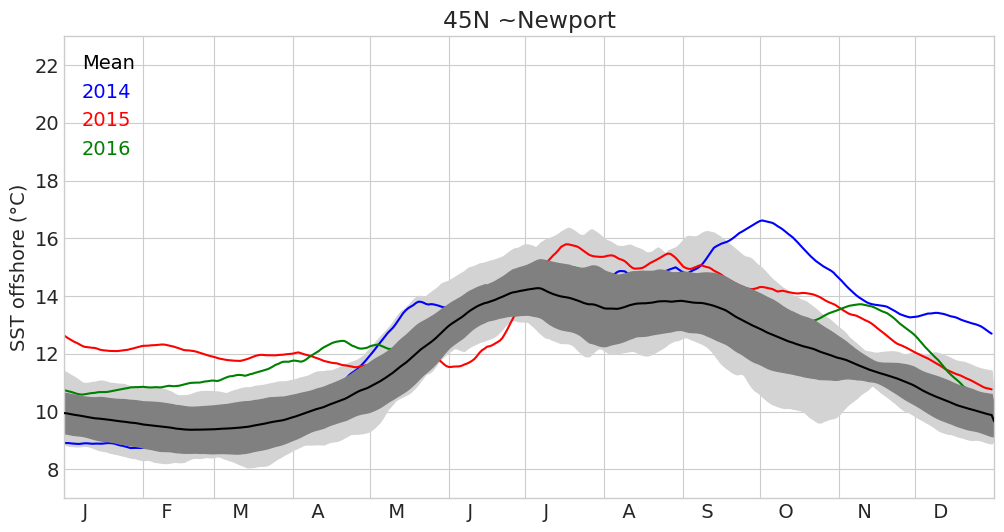

In [20]:
#plotting
plt.plot(SST_0213_mean, color="black", label="Mean", zorder=3)
plt.fill_between(list(range(len(SST_0213_mean))), SST_0213_max, SST_0213_min, color="lightgray", zorder=1)
plt.fill_between(list(range(len(SST_0213_mean))), SST_0213_upper_1sd, SST_0213_lower_1sd, color="gray", zorder=2)
plt.plot(SST_2014, color="blue", label="2014", zorder=1)
plt.plot(SST_2015, color="red", label="2015", zorder=1)
plt.plot(SST_2016, color="green", label="2016", zorder=1)

#legend
leg = plt.legend(labelcolor='linecolor', loc="upper left", handlelength=0, handletextpad=0, fancybox=True)

#title and axis
plt.title("45N ~Newport")
plt.ylabel("SST offshore (°C)")
plt.ylim(7, 23)
plt.xlim(0, 365)

months = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
new_m=[]
for m in months: 
    new_m.append('   %s'%m)
plt.xticks([0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334], new_m, horizontalalignment='left')

### Image Output ###
plt.savefig('./outputs/climate-Q6-Figure3b.png');